In [135]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import math
from matplotlib import pyplot as plt
from random import randrange
%matplotlib inline

dataSaveLocation = r'C:\Users\Ben\Desktop\School 2018-19\Rocket\SKYPILOT_BODY_IREC_2019.CSV.xlsx'

[    9.81   -19.62    39.24 ... -3256.92 -2432.88 -2060.1 ]


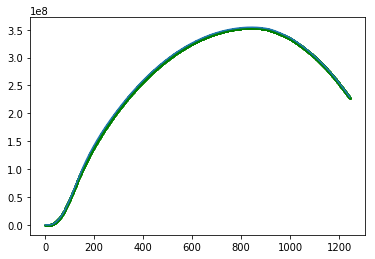

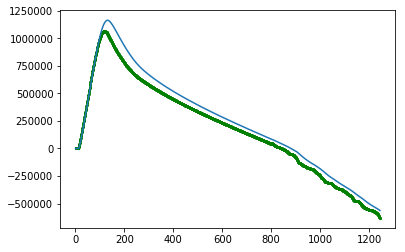

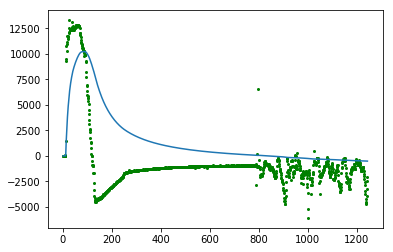

In [143]:
N = 100

#Import experimental data taken, load data into DataFrame
experimentData = pd.read_excel(dataSaveLocation,dtype=str)
df = pd.DataFrame(experimentData, columns=['Time (ms)','Accelerometer - Acceleration X (g)'])

np.set_printoptions(suppress=True)

aObservations = df['Accelerometer - Acceleration X (g)'][54756:56000].values
#aObservations = df['Accelerometer - Acceleration Z (g)'][0:10].values
aObservations = aObservations.astype(np.float)
aObservations = (aObservations - 1)*9.81*100
print(aObservations)
N = len(aObservations)

# Initial Conditions
a = 0  # Acceleration
v = 0
x = 0
t = 1  # Difference in time

xObservations = np.zeros(N)
vObservations = np.zeros(N)
#aObservations = np.zeros(N)

xObservations[0] = x
vObservations[0] = v
#aObservations[0] = a

for i in range(1,N):
    xObservations[i] = xObservations[i-1] + t*vObservations[i-1] + 0.5*aObservations[i-1]*(t**2)
    vObservations[i] = vObservations[i-1] + t*aObservations[i-1]
#     if(i<10):
#         aObservations[i] = 100 - 10*i + randrange(int(-30/i),int(30/i))
#     else:
#         aObservations[i] = -9.81
    

z = np.c_[xObservations, vObservations, aObservations]

# Process / Estimation Errors
error_est_x = 20
error_est_v = 5
error_est_a = 3

# Observation Errors
error_obs_x = 25  # Uncertainty in the measurement
error_obs_v = 6
error_obs_a = 4

def prediction3d(x, v, t, a):
    A = np.array([[1, t, 0.5*(t**2)],
                  [0, 1, t],
                  [0, 0, 1]])
    X = np.array([[x],
                  [v],
                  [a]])
#     B = np.array([[0.5 * t ** 2],
#                   [t]])
#     X_prime = A.dot(X) + B.dot(a)
#     return X_prime

    return A.dot(X)


def covariance3d(sigma1, sigma2, sigma3):
    cov1_2 = sigma1 * sigma2
    cov1_3 = sigma1 * sigma3
    cov2_1 = sigma2 * sigma1
    cov2_3 = sigma2 * sigma3
    cov3_1 = sigma3 * sigma1
    cov3_2 = sigma3 * sigma2
    cov_matrix = np.array([[sigma1 ** 2, cov1_2, cov1_3],
                           [cov2_1, sigma2 ** 2, cov2_3],
                           [cov3_1, cov3_2, sigma3 **2]])
    return np.diag(np.diag(cov_matrix))


# Initial Estimation Covariance Matrix
P = covariance3d(error_est_x, error_est_v, error_est_a)
A = np.array([[1, t, 0.5*(t**2)],
              [0, 1, t],
              [0, 0, 1]])

# Initial State Matrix
X = np.array([[x],
              [v],
              [a]])

plotX = []

plotX.append(X)

n = len(z[0])

for data in z[1:]:
    X = prediction3d(X[0][0], X[1][0], t, X[2][0])
    # To simplify the problem, professor
    # set off-diagonal terms to 0.
    P = np.diag(np.diag(A.dot(P).dot(A.T)))

    # Calculating the Kalman Gain
    H = np.identity(n)
    R = covariance3d(error_obs_x, error_obs_v, error_obs_a)
    S = H.dot(P).dot(H.T) + R
    K = P.dot(H).dot(inv(S))

    # Reshape the new data into the measurement space.
    Y = H.dot(data).reshape(n, -1)

    # Update the State Matrix
    # Combination of the predicted state, measured values, covariance matrix and Kalman Gain
    X = X + K.dot(Y - H.dot(X))
    
    plotX.append(X)

    # Update Process Covariance Matrix
    P = (np.identity(len(K)) - K.dot(H)).dot(P)

#print("Kalman Filter State Matrix:\n", plotX)

time = np.linspace(1,N,N)

#print(plotX)


position = [predict[0][0] for predict in plotX]
velocity = [predict[1][0] for predict in plotX]
acceleration = [predict[2][0] for predict in plotX]

plt.scatter(time,xObservations,s=4,c='Green')
plt.plot(time,position)
plt.show()

plt.scatter(time,vObservations,s=4,c='Green')
plt.plot(time,velocity)
plt.show()

plt.scatter(time,aObservations,s=4,c='Green')
plt.plot(time,acceleration)
plt.show()